In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
W, H = 900, 250

canvas = np.ones((H, W, 3), dtype=np.uint8) * 255

drawing = False
last_x, last_y = None, None

pen_thickness = 18
pen_color = (0, 0, 0)  

In [33]:
def mouse_draw(event, x, y, flags, param):
    global drawing, last_x, last_y, canvas

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        last_x, last_y = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.line(canvas, (last_x, last_y), (x, y), pen_color, pen_thickness, lineType=cv2.LINE_AA)
            last_x, last_y = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        last_x, last_y = None, None

In [34]:
cv2.namedWindow("LiveScribe Pad")
cv2.setMouseCallback("LiveScribe Pad", mouse_draw)

print("Controls: draw with mouse | c=clear | s=save | q=quit")

while True:
    cv2.imshow("LiveScribe Pad", canvas)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break
    elif key == ord("c"):
        canvas[:] = 255
    elif key == ord("s"):
        cv2.imwrite("draw.png", canvas)
        print("Saved draw.png")

cv2.destroyAllWindows()


Controls: draw with mouse | c=clear | s=save | q=quit
Saved draw.png


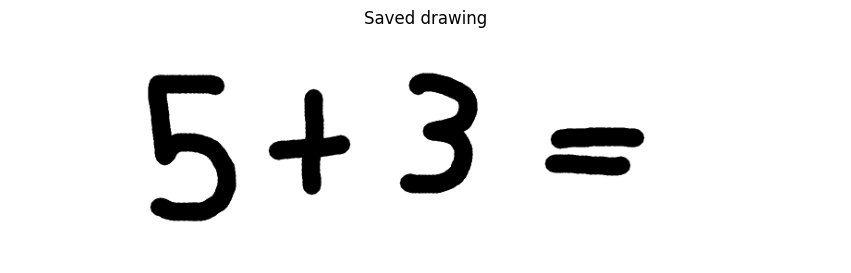

In [35]:
img = cv2.imread("draw.png")
if img is None:
    print("No draw.png found yet. Press 's' in the pad window to save.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 3))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Saved drawing")
    plt.show()


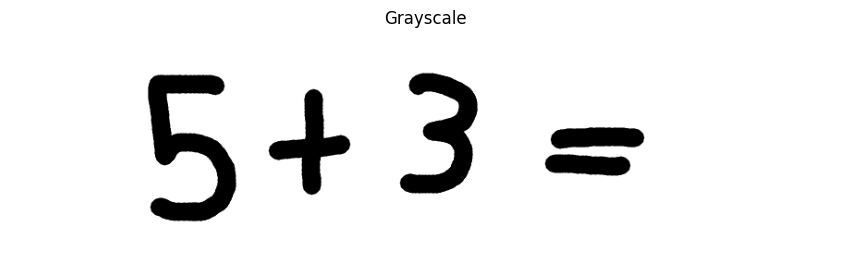

In [36]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 3))
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale")
plt.show()


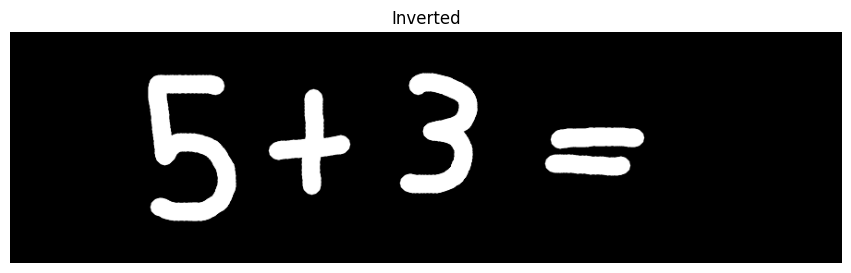

In [37]:
inv = 255 - gray

plt.figure(figsize=(12, 3))
plt.imshow(inv, cmap="gray")
plt.axis("off")
plt.title("Inverted")
plt.show()


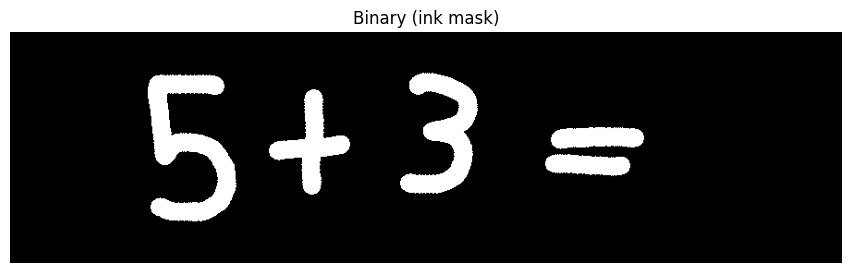

In [38]:
_, binary = cv2.threshold(
    inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.figure(figsize=(12, 3))
plt.imshow(binary, cmap="gray")
plt.axis("off")
plt.title("Binary (ink mask)")
plt.show()


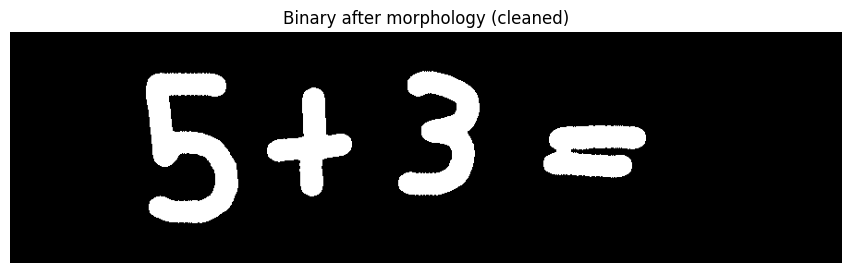

In [54]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

binary_clean = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary_clean = cv2.dilate(binary_clean, kernel, iterations=1)

plt.figure(figsize=(12, 3))
plt.imshow(binary_clean, cmap="gray")
plt.axis("off")
plt.title("Binary after morphology (cleaned)")
plt.show()


In [55]:
contours, _ = cv2.findContours(binary_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
min_area = 120  # increase if you still get small noise boxes

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w * h < min_area:
        continue
    boxes.append((x, y, w, h))

boxes = sorted(boxes, key=lambda b: b[0])
boxes


[(147, 44, 100, 163),
 (278, 60, 92, 118),
 (420, 42, 88, 135),
 (577, 101, 111, 57)]

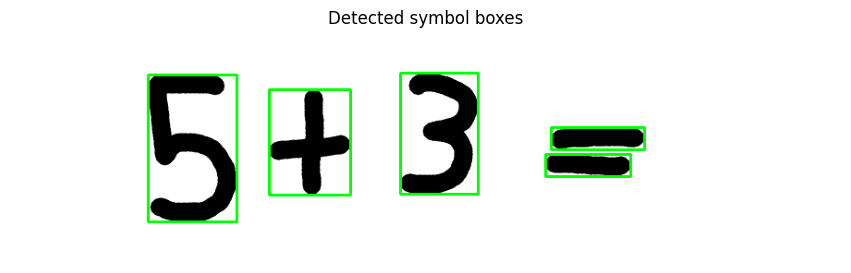

In [41]:
vis = img.copy()

for x, y, w, h in boxes:
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 3))
plt.imshow(vis_rgb)
plt.axis("off")
plt.title("Detected symbol boxes")
plt.show()


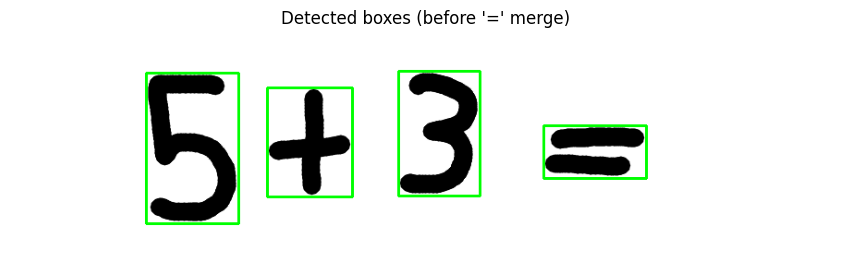

In [56]:
vis = img.copy()

for x, y, w, h in boxes:
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 3))
plt.imshow(vis_rgb)
plt.axis("off")
plt.title("Detected boxes (before '=' merge)")
plt.show()


In [57]:
def merge_equals_boxes(boxes, gap_factor=3.5, min_x_overlap=0.55):
    """
    Merge pairs of boxes that likely form an '=' sign.
    - gap_factor controls vertical distance tolerance (relative to stroke height)
    - min_x_overlap controls how aligned the two strokes are in x
    """
    boxes = sorted(boxes, key=lambda b: b[0])
    used = [False] * len(boxes)
    merged = []

    def x_overlap_ratio(a, b):
        ax1, ax2 = a[0], a[0] + a[2]
        bx1, bx2 = b[0], b[0] + b[2]
        inter = max(0, min(ax2, bx2) - max(ax1, bx1))
        smaller = min(a[2], b[2])
        return inter / smaller if smaller > 0 else 0.0

    def y_center(b):
        return b[1] + b[3] / 2

    for i in range(len(boxes)):
        if used[i]:
            continue

        x1, y1, w1, h1 = boxes[i]

        # must look like a horizontal stroke
        if w1 < 2.0 * h1:
            used[i] = True
            merged.append(boxes[i])
            continue

        best_j = -1
        best_score = 0.0

        for j in range(i + 1, len(boxes)):
            if used[j]:
                continue

            x2, y2, w2, h2 = boxes[j]

            if w2 < 2.0 * h2:
                continue

            width_ratio = min(w1, w2) / max(w1, w2)
            height_ratio = min(h1, h2) / max(h1, h2)
            if width_ratio < 0.5 or height_ratio < 0.35:
                continue

            max_y_gap = gap_factor * max(h1, h2)
            y_gap = abs(y_center(boxes[i]) - y_center(boxes[j]))
            if y_gap > max_y_gap:
                continue

            overlap = x_overlap_ratio(boxes[i], boxes[j])
            if overlap < min_x_overlap:
                continue

            score = overlap * 0.7 + width_ratio * 0.2 + height_ratio * 0.1
            if score > best_score:
                best_score = score
                best_j = j

        if best_j != -1:
            used[i] = True
            used[best_j] = True

            xa, ya, wa, ha = boxes[i]
            xb, yb, wb, hb = boxes[best_j]

            x = min(xa, xb)
            y = min(ya, yb)
            x2 = max(xa + wa, xb + wb)
            y2 = max(ya + ha, yb + hb)

            merged.append((x, y, x2 - x, y2 - y))
        else:
            used[i] = True
            merged.append(boxes[i])

    merged = sorted(merged, key=lambda b: b[0])
    return merged


boxes_merged = merge_equals_boxes(boxes, gap_factor=3.5, min_x_overlap=0.55)

print("Before:", len(boxes), "After:", len(boxes_merged))
boxes_merged


Before: 4 After: 4


[(147, 44, 100, 163),
 (278, 60, 92, 118),
 (420, 42, 88, 135),
 (577, 101, 111, 57)]

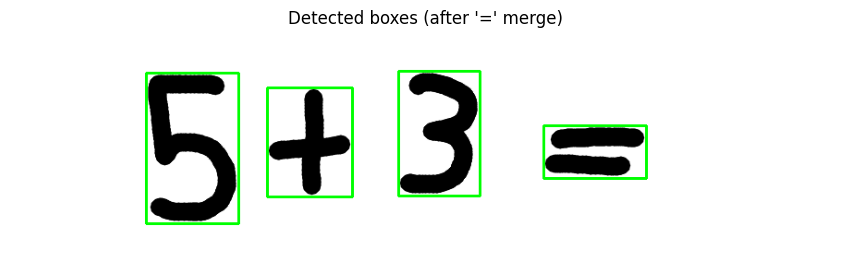

In [58]:
vis2 = img.copy()

for x, y, w, h in boxes_merged:
    cv2.rectangle(vis2, (x, y), (x + w, y + h), (0, 255, 0), 2)

vis2_rgb = cv2.cvtColor(vis2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 3))
plt.imshow(vis2_rgb)
plt.axis("off")
plt.title("Detected boxes (after '=' merge)")
plt.show()


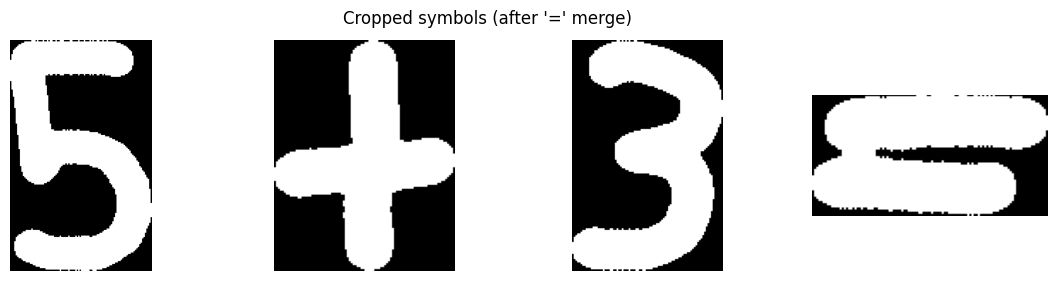

In [59]:
crops = []
for x, y, w, h in boxes_merged:
    crop = binary_clean[y:y+h, x:x+w]
    crops.append(crop)

plt.figure(figsize=(14, 3))
n = min(len(crops), 12)

for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(crops[i], cmap="gray")
    plt.axis("off")

plt.suptitle("Cropped symbols (after '=' merge)")
plt.show()


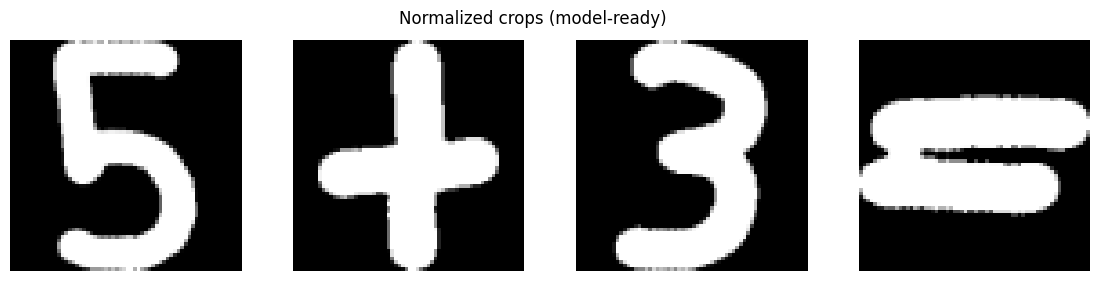

In [60]:
SIZE = 64

def pad_to_square(img2d):
    h, w = img2d.shape
    side = max(h, w)
    top = (side - h) // 2
    bottom = side - h - top
    left = (side - w) // 2
    right = side - w - left
    return cv2.copyMakeBorder(img2d, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

normalized = []
for c in crops:
    sq = pad_to_square(c)
    resized = cv2.resize(sq, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
    normalized.append(resized)

plt.figure(figsize=(14, 3))
n = min(len(normalized), 12)

for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(normalized[i], cmap="gray")
    plt.axis("off")

plt.suptitle("Normalized crops (model-ready)")
plt.show()
